In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
# import file
df = pd.read_csv("D:/Kaggle Dataset/us-accidents/US_Accidents_June20.csv",index_col='ID',parse_dates=['Start_Time','End_Time'])

In [4]:
from datetime import datetime, date
# adding time variables

df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday
df['Day'] = df['Start_Time'].dt.day
df['Impact'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds()/60 # duration
df["YMD"] = df["Start_Time"].dt.date

In [5]:
# classifying the features

numerical_features = ['Start_Lat','Start_Lng','Distance(mi)','Temperature(F)',
                     'Humidity(%)', 'Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']


binary_features = ['Amenity', 'Bump', 'Crossing','Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
                   'Station','Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Sunrise_Sunset']

categorical_features = ['Street', 'Side', 'City', 'County', 'State','Country', 'Timezone','Weather_Condition',
                       'Month', 'Year', 'Hour', 'Weekday', 'Day']

In [6]:
# transform the categorical variables into binary variables

df.loc[df["Sunrise_Sunset"] == "Day","Sunrise_Sunset"] = 1
df.loc[df["Sunrise_Sunset"] == "Night","Sunrise_Sunset"] = 0

In [7]:
# Massachusetts data
MA_df = df[df["State"] == "MA"]

In [8]:
# frequency of severity data in each state
sev_count = df.groupby("State")["Severity"].value_counts()
sev_count.unstack()

Severity,1,2,3,4
State,,,,
AL,133.0,30002.0,13890.0,600.0
AR,11.0,1011.0,488.0,502.0
AZ,6705.0,55089.0,13178.0,3612.0
CA,5801.0,576742.0,225820.0,8462.0
CO,519.0,25516.0,19888.0,3808.0
CT,22.0,12002.0,11632.0,2245.0
DC,43.0,2991.0,1099.0,687.0
DE,10.0,4288.0,629.0,812.0
FL,3014.0,165506.0,80563.0,8919.0


# Time Series

In [9]:
cols = ["Severity","Temperature(F)",'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)',"Sunrise_Sunset","YMD"]

In [10]:
df1 = MA_df[cols].copy()
df1.dropna(inplace=True)
# df1.ffill(inplace = True)
# df1.bfill(inplace = True)
df1.shape

(33312, 8)

In [11]:
# create daily variables
daily_group = df1.groupby("YMD")

daily_accident_count = daily_group["Severity"].count()
daily_severity_sum = daily_group["Severity"].sum()
daily_temp_mean = daily_group["Temperature(F)"].mean()
daily_hmd = daily_group['Humidity(%)'].mean()
daily_pres = daily_group['Pressure(in)'].mean()
daily_vis = daily_group['Visibility(mi)'].mean()
daily_wind = daily_group['Wind_Speed(mph)'].mean()
daily_sun = daily_group["Sunrise_Sunset"].sum()
# daily_twi = daily_group["Civil_Twilight"].sum()
# daily_nau = daily_group["Nautical_Twilight"].sum()
# daily_ast = daily_group["Astronomical_Twilight"].sum()

daily_data = pd.DataFrame({
    "Num" : daily_accident_count,
    "Severity" : daily_severity_sum,
    "Temp" : daily_temp_mean,
    "Humidity" : daily_hmd,
    "Pressure" : daily_pres,
    "Visibility" : daily_vis,
    "Wind_Speed" : daily_wind,
    "Sun" : daily_sun
#    "Twi" : daily_twi,
#    "Nau" : daily_nau,
#    "Astro" : daily_ast
})

In [12]:
# cols = ["Num","Severity","Temp","Humidity","Pressure","Visibility","Wind_Speed","Sun"]

In [13]:
daily_data.head(10)

,Num,Severity,Temp,Humidity,Pressure,Visibility,Wind_Speed,Sun
YMD,,,,,,,,
2016-03-24,5,10,37.420000,50.800000,30.248000,10.000000,15.640000,3
2016-03-25,3,7,45.333333,84.666667,29.813333,4.666667,9.600000,3
2016-03-28,7,15,41.114286,88.000000,29.791429,6.285714,8.400000,7
2016-03-29,6,12,43.133333,56.333333,29.683333,10.000000,18.433333,6
2016-03-30,3,6,42.633333,36.666667,30.280000,10.000000,10.000000,3
2016-03-31,3,6,62.000000,44.333333,29.910000,10.000000,23.800000,2
2016-04-04,9,19,24.488889,81.222222,30.011111,2.288889,7.066667,7
2016-04-05,7,14,26.128571,42.714286,30.250000,10.000000,10.042857,7
2016-04-07,8,19,54.312500,83.375000,29.815000,6.812500,17.700000,8


In [14]:
# standardization by hand

def stand_trans(x):
    x = x-min(x)
    x /= max(x)
    return x

In [15]:

# daily_data["Num"] = daily_data["Num"] / max(daily_data["Num"])
# daily_data["Severity"] /= daily_data["Num"]

daily_data["Visibility"] /= 10

daily_data["Wind_Speed"] = stand_trans(daily_data["Wind_Speed"])
daily_data["Pressure"] = stand_trans(daily_data["Pressure"])
daily_data["Temp"] = stand_trans(daily_data["Temp"])
daily_data["Humidity"] /= 100

daily_data["Sun"] = daily_data["Sun"] / daily_data["Num"]


In [16]:
daily_data.head(10)

,Num,Severity,Temp,Humidity,Pressure,Visibility,Wind_Speed,Sun
YMD,,,,,,,,
2016-03-24,5,10,0.388495,0.508000,0.790007,1.000000,0.522567,0.600000
2016-03-25,3,7,0.478244,0.846667,0.618140,0.466667,0.320757,1.000000
2016-03-28,7,15,0.430394,0.880000,0.609479,0.628571,0.280663,1.000000
2016-03-29,6,12,0.453293,0.563333,0.566739,1.000000,0.615899,1.000000
2016-03-30,3,6,0.447622,0.366667,0.802660,1.000000,0.334122,1.000000
2016-03-31,3,6,0.667269,0.443333,0.656362,1.000000,0.795211,0.666667
2016-04-04,9,19,0.241837,0.812222,0.696342,0.228889,0.236113,0.777778
2016-04-05,7,14,0.260434,0.427143,0.790798,1.000000,0.335554,1.000000
2016-04-07,8,19,0.580082,0.833750,0.618799,0.681250,0.591396,1.000000


In [17]:
daily_data.corr()

,Num,Severity,Temp,Humidity,Pressure,Visibility,Wind_Speed,Sun
Num,1.000000,0.995017,-0.107821,0.155830,-0.126454,-0.182184,0.015987,-0.134419
Severity,0.995017,1.000000,-0.096007,0.152590,-0.124651,-0.181255,0.022859,-0.118887
Temp,-0.107821,-0.096007,1.000000,0.048104,-0.151357,0.164363,-0.148031,0.454771
Humidity,0.155830,0.152590,0.048104,1.000000,-0.250906,-0.630246,-0.211890,-0.095259
Pressure,-0.126454,-0.124651,-0.151357,-0.250906,1.000000,0.213590,-0.227455,-0.023102
Visibility,-0.182184,-0.181255,0.164363,-0.630246,0.213590,1.000000,-0.001479,0.083208
Wind_Speed,0.015987,0.022859,-0.148031,-0.211890,-0.227455,-0.001479,1.000000,0.072498
Sun,-0.134419,-0.118887,0.454771,-0.095259,-0.023102,0.083208,0.072498,1.000000


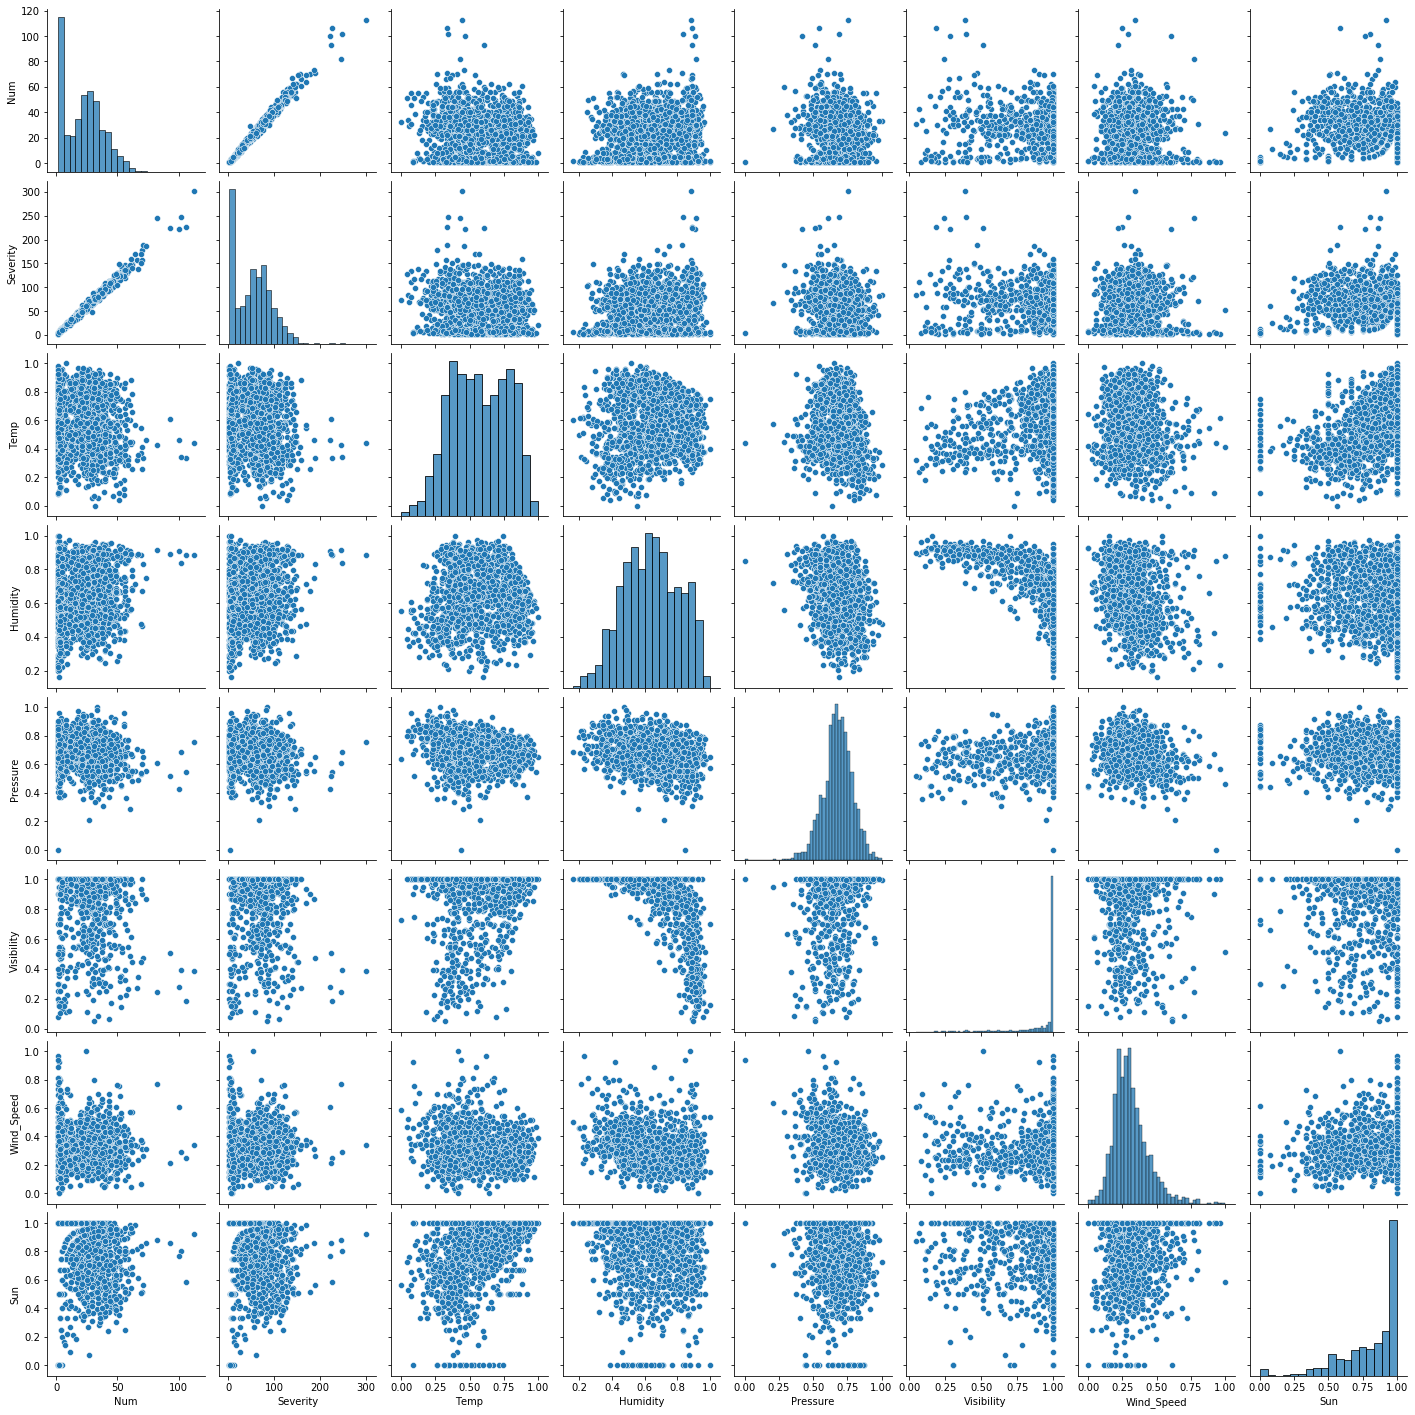

In [18]:
# doing linear standardization has no influence to the correlation coefficient
sns.pairplot(daily_data)

# Linear Model

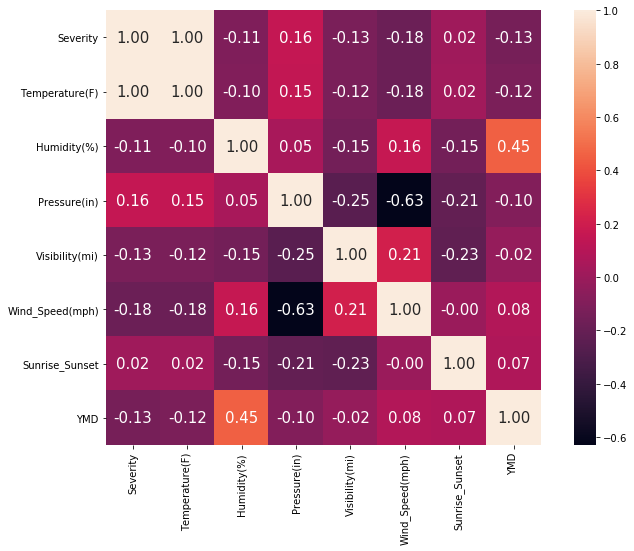

In [19]:
plt.figure(figsize = (12,8))
sns.heatmap(daily_data.corr(),cbar=True, annot=True,square=True,
                 fmt='.2f',annot_kws={'size': 15},
                 yticklabels=cols,xticklabels=cols);

## Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
linear_features = ["Temp","Humidity","Pressure","Visibility","Wind_Speed"]

Using weather data to predict the proportion of accidents happened at daytime

This time I choose only one feature: temperature

In [22]:
#X = daily_data[linear_features]
X = daily_data[["Temp"]]
y = daily_data["Sun"]

It seems that there is no need to do standardization

In [23]:
# standardization by hand
# daily_data["Visibility"] /= 10

#daily_data["Wind_Speed"] = stand_trans(daily_data["Wind_Speed"])
#daily_data["Pressure"] = stand_trans(daily_data["Pressure"])
#daily_data["Temp"] = stand_trans(daily_data["Temp"])
#daily_data["Humidity"] /= 100

#daily_data["Sun"] = daily_data["Sun"] / daily_data["Num"]


In [19]:
# or standardization by standard scaler
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

In [27]:
# PCA
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)

#try:
#    X_r = pca.fit(X).transform(X)
#except ValueError:
#    print("Error: n<2")

In [23]:
lr = LinearRegression()

In [24]:
# cross-val-score
scores = cross_val_score(lr,X,y)
np.mean(scores)

0.16379207787451816

In [25]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [26]:
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.033485573752112516
0.2739603895681487


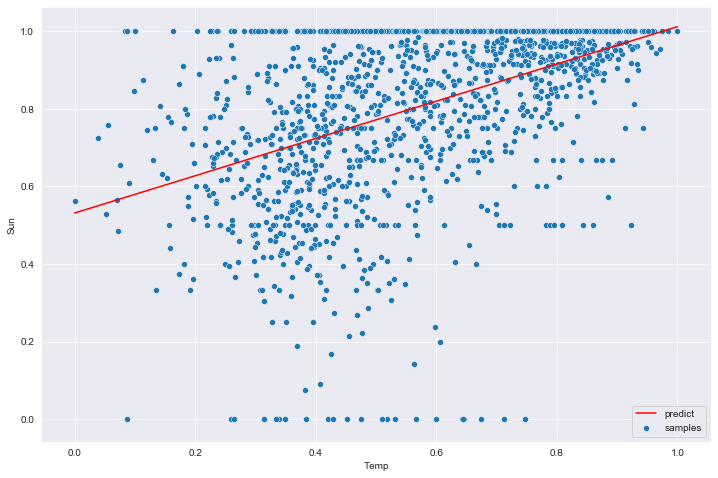

In [30]:
x_points = np.linspace(0,1,100)

sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.scatterplot(x="Temp",y="Sun",data = daily_data,label="samples")
plt.plot(x_points,lr.predict(x_points[:,np.newaxis]),color="red",label="predict")
plt.legend(loc="lower right")

## Polynomial Regression

Predict the proportion of accidents at daytime

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
mean_scores = []
for i in range(1,15):
    poly = PolynomialFeatures(degree=i)
    X2 = poly.fit_transform(X)
    lr = LinearRegression()
    scores = cross_val_score(lr,X2,y)
    mean_scores.append(np.mean(scores))  

In [34]:
print(mean_scores)

[0.16379207787451847, 0.16228331329181117, 0.17005772825449547, 0.16991330937207402, 0.17027997964056413, 0.17004316563842878, 0.1699974243379781, 0.16721850252322565, 0.16373953359243507, 0.09996197404178016, -0.05289282567055351, -0.09060618911431426, -0.18615175023810981, 0.02762864074097058]


Text(0.5, 1.0, 'Degree 3\nMSE = -0.03(+/- 0.21)')

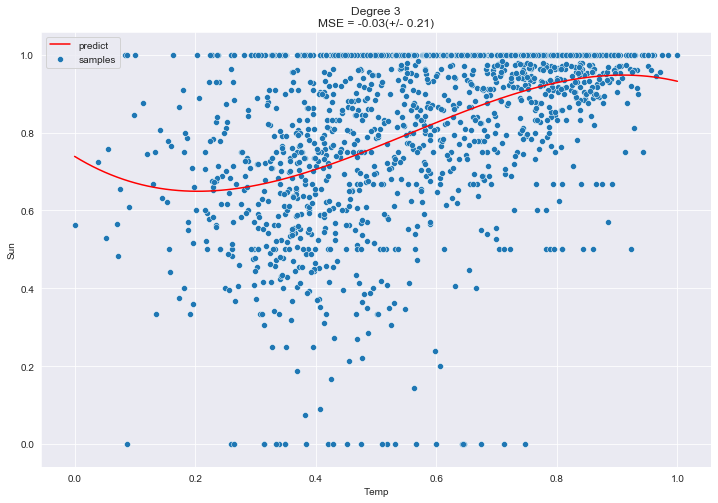

In [39]:
poly = PolynomialFeatures(degree=3)
lr = LinearRegression()
pipeline = Pipeline([("polynomial_features", poly),
                         ("linear_regression", lr)])
pipeline.fit(X, y)

x_points = np.linspace(0,1,100)

sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.scatterplot(x="Temp",y="Sun",data = daily_data,label="samples")
plt.plot(x_points,pipeline.predict(x_points[:,np.newaxis]),color="red",label="predict")
plt.legend(loc="best")
plt.title("Degree {}\nMSE = {:.2f}(+/- {:.2f})".format(
        3, -scores.mean(), scores.std()))

There is a little improvement by using polynomial regression, but I think this is not the best method, maybe using a log function is better.

Predict the visualizaion by humidity

In [60]:
Humid = daily_data[["Humidity"]]
Visib = daily_data["Visibility"]

In [65]:
X = np.array(Humid)
y = np.array(Visib)

In [61]:
mean_scores = []
for i in range(1,11):
    poly = PolynomialFeatures(degree=i)
    Humid2 = X2 = poly.fit_transform(Humid)
    lr = LinearRegression()
    scores = cross_val_score(lr,Humid2,Visib)
    mean_scores.append(np.mean(scores))  

In [62]:
print(mean_scores)

[0.3912668913012712, 0.5714723682255787, 0.6048924605623548, 0.6040303981963999, 0.6058631552502757, 0.6092475133886653, 0.6098067386920647, 0.6090261464824891, 0.6082507679024467, 0.6077832912735861]


In [87]:
poly = PolynomialFeatures(degree=3)
lr = LinearRegression()
pipeline = Pipeline([("polynomial_features", poly),
                         ("linear_regression", lr)])
pipeline.fit(X, y)

scores = cross_val_score(pipeline, X, y,
                             scoring="neg_mean_squared_error", cv=10)

# train-test-split
# X_train, X_test, y_train, y_test = train_test_split(Humid2, Visib, test_size=0.1)


Text(0.5, 1.0, 'Degree 3\nMSE = 1.52(+/- 0.42)')

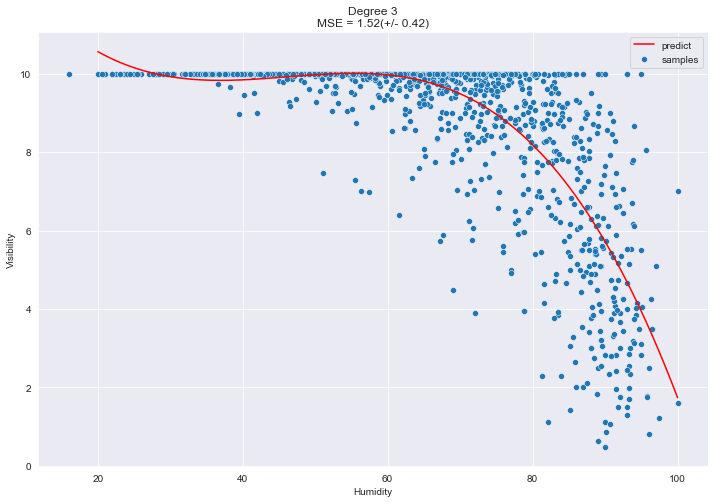

In [88]:
x_test = np.linspace(20,100,1000)

sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.scatterplot(x="Humidity",y="Visibility",data = daily_data,label="samples")
plt.plot(x_test,pipeline.predict(x_test[:,np.newaxis]),color="red",label="predict")
plt.legend(loc="best")
plt.title("Degree {}\nMSE = {:.2f}(+/- {:.2f})".format(
        3, -scores.mean(), scores.std()))

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [42]:
df1 = MA_df.copy()
df1.ffill(inplace = True)
df1.bfill(inplace=True)

In [43]:
# simplify Severity into 2 groups
df1.loc[df1["Severity"] <= 2,"Severity"] = 0
df1.loc[df1["Severity"] >= 3,"Severity"] = 1

In [44]:
df1.Severity.value_counts()

0    23635
1    15409
Name: Severity, dtype: int64

The number of two classes are inbalanced, and we must handel this problem, otherwise the model will be inaccurate.

I choose a simple way: using repetitive rows to fill the data set

In [45]:
# length of the data set
n = len(df1.Severity)
df1_type1 = df1[df1.Severity == 1]
n1 = len(df1_type1.Severity)

# randomly choose the rows and then fill the data set
j = df1_type1.iloc[np.random.randint(n1,size = n-2*n1)]
df1 = df1.append(j)

In [46]:
df1.Severity.value_counts()

1    23635
0    23635
Name: Severity, dtype: int64

In [47]:
# create the model
y = df1["Severity"].copy()
X = df1[numerical_features + binary_features].copy()
lor = LogisticRegression(random_state=0)

In [48]:
# 1. Standardization
#
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X[numerical_features])
#
#X.loc[:,numerical_features] = scaler.transform(X[numerical_features])

In [49]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
lor.fit(X_train,y_train)
y_pred=lor.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.5971017558705309

In [51]:
# cross validation
scores = cross_val_score(lor,X,y)

In [52]:
np.mean(scores)

0.5760736196319017

## LDA

This part is not finished

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
lda_model = lda.fit(X, y)
X_r2 = lda_model.transform(X)
X_r2[0:5]
lda_model.coef_
print(np.max(lda_model.coef_,axis=1))
print(np.argmax(lda_model.coef_,axis=1))
lda_model.means_

# Clustering

I think it's a good idea to make a clustering model on the "state" data, because we can split the 51 states into different groups (clusters), and put forward some conclusions or suggestions to each state group.

The variables I choose is the proportion of accidents that are severe (greater than 2), and the proportion of accidents that happen at daytime.

In [90]:
# Simplify the severity variable into 2 classes
df1 = df.copy()
df1.loc[df1["Severity"] <= 2,"Severity"] = 0
df1.loc[df1["Severity"] >= 3,"Severity"] = 1

In [123]:
# calculating the 2 variables of each state
state_group = df1.groupby("State")
state_info = (state_group["Severity"].sum() / state_group["Severity"].count()).reset_index()
state_info.loc[:,"at_daytime"] = np.array(state_group["Sunrise_Sunset"].sum() / state_group["Sunrise_Sunset"].count())
state_info.head()

In [92]:
# city_group = df1.groupby("City")
# city_severe = city_group["Severity"].sum() / city_group["Severity"].count()

# city_sun = city_group["Sunrise_Sunset"].sum() / city_group["Sunrise_Sunset"].count()

#city_info = pd.DataFrame({
#    "Severity" : city_severe,
#    "at_Daytime" : city_sun
#})

Text(0.5, 1.0, 'Relationship of severity and at_daytime of each state')

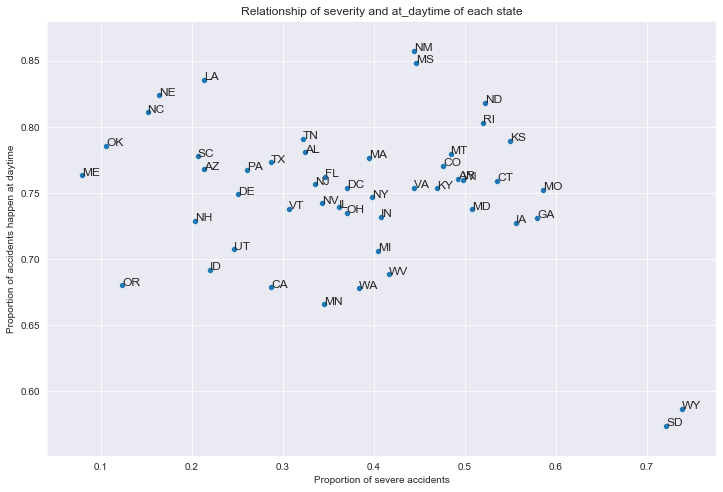

In [151]:
# ploting the data

plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
sns.scatterplot(x="Severity",y="at_daytime",data=state_info)
for i in range(len(state_info.Severity)):
    plt.text(x=state_info.loc[i,"Severity"],y=state_info.loc[i,"at_daytime"],s=state_info.loc[i,"State"],
            fontsize = 12)
plt.xlabel("Proportion of severe accidents")
plt.ylabel("Proportion of accidents happen at daytime")
plt.title("Relationship of severity and at_daytime of each state")

We can see that South Dakota and Wyoming is far away from other states, so it may worth doing a clustering model

In [152]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs, make_moons

## K means

In [155]:
# feature
X = state_info[["Severity","at_daytime"]]

In [156]:
# model
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [157]:
# center 
centers = kmeans.cluster_centers_
print(centers)

[[0.35581591 0.73575805]
 [0.50711928 0.7750319 ]
 [0.72975023 0.58019233]
 [0.18760417 0.76072253]]


Text(0.5, 1.0, 'K means clustering')

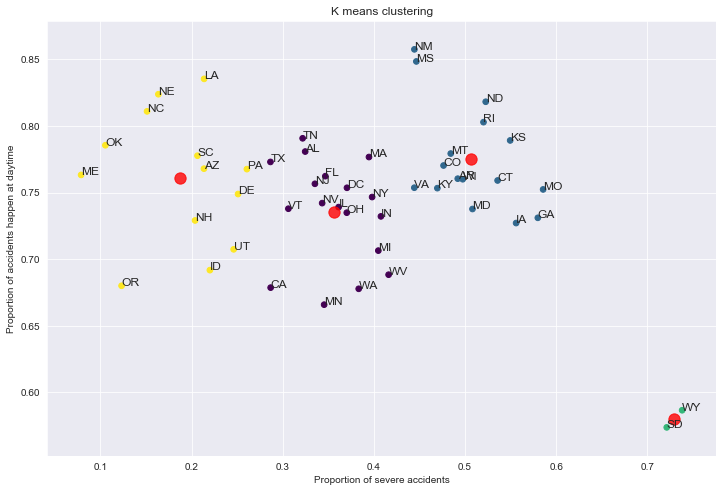

In [160]:
# plotting
X1 = np.array(X)
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
plt.scatter(X1[:, 0], X1[:, 1], c=y_kmeans, s=32, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=128, alpha=0.8)
for i in range(len(state_info.Severity)):
    plt.text(x=state_info.loc[i,"Severity"],y=state_info.loc[i,"at_daytime"],s=state_info.loc[i,"State"],
            fontsize = 12)
plt.xlabel("Proportion of severe accidents")
plt.ylabel("Proportion of accidents happen at daytime")
plt.title("K means clustering")

To find a best number of clusters, I utilize Davies-Bouldin Index:

$DBI=\frac{1}{k}\sum_{i=1}^k\max \limits_{j\neq i}\left(\frac{avg\left(C_i\right)+avg\left(C_j\right)}{d_{cen}\left(\mu_i ,\mu_j \right)}\right)$

In [176]:
from sklearn.metrics import davies_bouldin_score

In [173]:
n_clusters = np.arange(2, 20)

models = [KMeans(n,random_state=0).fit(X)
         for n in n_clusters]

metrics = [davies_bouldin_score(X,model.predict(X)) for model in models]

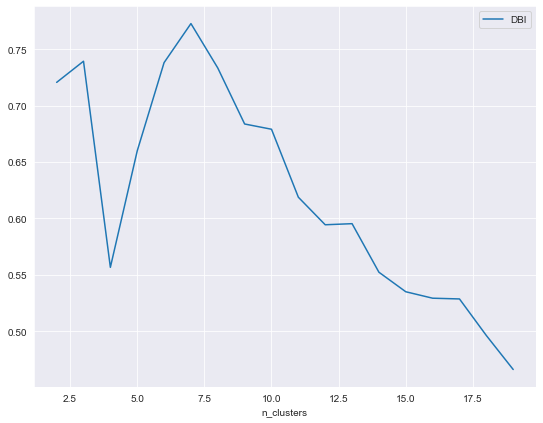

In [174]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(n_clusters, metrics, label='DBI')

plt.legend(loc='best')
plt.xlabel('n_clusters');

A good model should have smaller DBI, so choosing 4 as the number of cluster might be the best, since too many clusters could lead to overfitting.